# LSTM model
Using only temperature in Model1.0
### features
tmp of the select_stations
day of the week
hour of the day
month of the year

### prediction frame
with n = 6 and m = 4
features:
t-n to t+m-1 of temperature
labels:
t to t+m-1 of load ERCOT

In [1]:
import sys
 
# setting path
sys.path.append('../../../data')
from data import *

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,  Flatten

import matplotlib.pyplot as plt

from statistics import mean, stdev
import pandas as pd
import numpy as np
import datetime

In [3]:
start = datetime.datetime.now()

In [4]:
past_hours = 6
n_steps = past_hours
next_hours = 4
next_steps = next_hours

In [5]:
transformations = ['tmp'+str(n) for n in select_stations]
transformations = [(str(i), MinMaxScaler(copy=True), make_column_selector(pattern = e)) for i,e in enumerate(transformations)]
transformations += [("y",StandardScaler(copy=True), make_column_selector(pattern = 'ERCOT'))]
ct = ColumnTransformer(transformations)

normed_data = pd.DataFrame(ct.fit_transform(load_data))
normed_data

,0,1,2,3,4,5,6,7,8
0,0.487742,0.515970,0.538541,0.569868,0.574341,0.492591,0.558266,0.548785,-0.861036
1,0.450905,0.474372,0.503909,0.526833,0.519649,0.460071,0.513164,0.517790,-0.727637
2,0.414036,0.432791,0.469412,0.483889,0.464860,0.427550,0.467992,0.486960,-0.782265
3,0.397926,0.426221,0.448930,0.466264,0.441615,0.413398,0.451389,0.470350,-0.941622
4,0.381831,0.419720,0.428448,0.448602,0.418254,0.399198,0.434717,0.453722,-1.188049
...,...,...,...,...,...,...,...,...,...
94909,0.414130,0.625292,0.471742,0.637836,0.623824,0.581990,0.652609,0.670257,0.436792
94910,0.418746,0.610454,0.453827,0.625314,0.600579,0.573971,0.638006,0.652986,0.269458
94911,0.417530,0.605925,0.454671,0.623405,0.592086,0.567664,0.626110,0.643073,0.129600
94912,0.416313,0.601551,0.455516,0.621477,0.583709,0.561372,0.614196,0.633274,-0.005014


In [6]:
dataset = normed_data.values
steps = n_steps+next_steps
time_series =  np.array([dataset[i:i + steps].copy() for i in range(len(dataset) - steps) if load_data.index[i+steps] - load_data.index[i] == datetime.timedelta(hours=steps)])

time_series.shape

(94378, 10, 9)

In [7]:
X = time_series[:, :n_steps, :]
Y = time_series[:, n_steps:, -1]

print(X.shape, Y.shape)

(94378, 6, 9) (94378, 4)


In [8]:
#sizes for test, train, and validation datasets
a = len(time_series)
b = int(0.9*a)
c = int(a-b)//2

In [9]:
X_train,    Y_train =   X[:b],      Y[:b]
X_val,      Y_val   =   X[b:b+c],   Y[b:b+c]
X_test,     Y_test  =   X[b+c:],    Y[b+c:]

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

(84940, 6, 9) (4719, 6, 9) (4719, 6, 9)
(84940, 4) (4719, 4) (4719, 4)


In [10]:
model = Sequential([
    Flatten(input_shape=(X_train.shape[1],X_train.shape[2])),
    Dense(256, activation="sigmoid"),
    Dense(128, activation="sigmoid"),
    Dropout(0.1),
    Dense(128, activation="sigmoid"),
    Dropout(0.1),
    Dense(128, activation="sigmoid"),
    Dense(128, activation="relu"),
    Dropout(0.1),
    Dense(next_steps)
])

In [11]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(5e-4,
                                                decay_steps=1000000,
                                                decay_rate=0.98,
                                                  staircase=False)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=1e-6)

model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 54)                0         
                                                                 
 dense (Dense)               (None, 256)               14080     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               1

In [12]:
EPOCHS = 30

history = model.fit(
  X_train, Y_train,
  epochs=EPOCHS, validation_data = (X_val, Y_val), shuffle=False, verbose=1)

Epoch 1/30
2655/2655 [==============================] - 17s 5ms/step - loss: 0.1761 - mae: 0.3125 - mse: 0.1761 - val_loss: 0.1836 - val_mae: 0.3142 - val_mse: 0.1836
Epoch 2/30
2655/2655 [==============================] - 13s 5ms/step - loss: 0.0871 - mae: 0.2261 - mse: 0.0871 - val_loss: 0.1507 - val_mae: 0.2876 - val_mse: 0.1507
Epoch 3/30
2655/2655 [==============================] - 14s 5ms/step - loss: 0.0741 - mae: 0.2082 - mse: 0.0741 - val_loss: 0.1270 - val_mae: 0.2549 - val_mse: 0.1270
Epoch 4/30
2655/2655 [==============================] - 14s 5ms/step - loss: 0.0649 - mae: 0.1946 - mse: 0.0649 - val_loss: 0.1066 - val_mae: 0.2351 - val_mse: 0.1066
Epoch 5/30
2655/2655 [==============================] - 14s 5ms/step - loss: 0.0587 - mae: 0.1849 - mse: 0.0587 - val_loss: 0.0955 - val_mae: 0.2216 - val_mse: 0.0955
Epoch 6/30
2655/2655 [==============================] - 14s 5ms/step - loss: 0.0549 - mae: 0.1784 - mse: 0.0549 - val_loss: 0.0895 - val_mae: 0.2157 - val_mse: 0.089

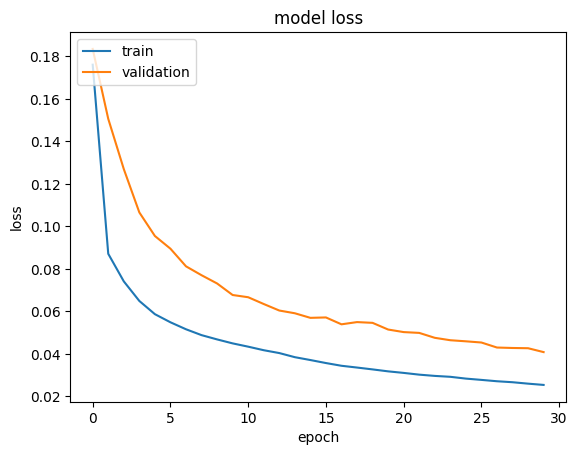

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
test_predictions = model.predict(X_test)
op_list= [e for y in test_predictions for e in y]   #predicted list
ip_list = [e for y in Y_test for e in y]    #actual list
print(len(op_list), len(ip_list))

148/148 [==============================] - 1s 3ms/step
18876 18876


In [26]:
test_labels = pd.DataFrame({'actual':ip_list})
predictions = pd.DataFrame({'predict':op_list})
test_labels['actual'] = ct.named_transformers_['y'].inverse_transform(test_labels)
predictions['predict'] = ct.named_transformers_['y'].inverse_transform(predictions)

error = predictions['predict'] - test_labels['actual']
rerror = 100*(predictions['predict'] - test_labels['actual'])/test_labels['actual']

print('Mean of error in test data:', mean(error))
print('Mean of absolute error in test data:', mean(abs(error)))
print('Root of mean of squared error in test data:', mean(error**2)**0.5)
print('Standard deviation of error in test data:', stdev(error))
print("=============================================================")
print('MPE (%):', mean(rerror))
print('MAPE (%):', mean(abs(rerror)))
print('RMSPE (%):', mean(rerror**2)**0.5)
print('Deviation of error (%):', stdev(rerror))
print("=============================================================")
print('Mean of test data:', mean(test_labels['actual']))
print('Standard deviation of test data:', stdev(test_labels['actual']))
print("Coefficient of determination:",r2_score(test_labels['actual'], predictions['predict']))

Mean of error in test data: -1268.3885834235602
Mean of absolute error in test data: 2062.3157852936597
Root of mean of squared error in test data: 3124.293035322946
Standard deviation of error in test data: 2855.315969748496
MPE (%): -1.9514264207593408
MAPE (%): 3.9904695856231474
RMSPE (%): 5.572005196913026
Deviation of error (%): 5.21925473357882
Mean of test data: 47586.94378734902
Standard deviation of test data: 10122.94285891266
Coefficient of determination: 0.9047394775649362


In [16]:
#absolute errors
for threshold in [5,10,50,100,500,1000,1500,2000,3000,4000,5000]:
    accuracy = sum(abs(e) < threshold for e in error)/len(error)*100
    print('accuracy:', accuracy,'% with threshold of', threshold)

accuracy: 0.15363424454333544 % with threshold of 5
accuracy: 0.42381860563678747 % with threshold of 10
accuracy: 2.0343293070565798 % with threshold of 50
accuracy: 3.9838948929858025 % with threshold of 100
accuracy: 20.157872430599703 % with threshold of 500
accuracy: 41.69845306208943 % with threshold of 1000
accuracy: 57.718796355159995 % with threshold of 1500
accuracy: 67.62025852934944 % with threshold of 2000
accuracy: 79.30705657978385 % with threshold of 3000
accuracy: 85.56897647806738 % with threshold of 4000
accuracy: 89.55287137105319 % with threshold of 5000


In [17]:
#relative errors
for threshold in [0.5,1,1.5,2,3,4,5]:
    accuracy = sum(abs(e) < threshold for e in rerror)/len(error)*100
    print('accuracy:', accuracy,'% with threshold of', threshold)

accuracy: 8.248569612205976 % with threshold of 0.5
accuracy: 17.048103411739778 % with threshold of 1
accuracy: 26.584022038567497 % with threshold of 1.5
accuracy: 36.27887264250901 % with threshold of 2
accuracy: 52.68595041322314 % with threshold of 3
accuracy: 64.83365119728755 % with threshold of 4
accuracy: 73.13519813519814 % with threshold of 5


In [18]:
import matplotlib
matplotlib.rcParams.update({'font.size': 48})

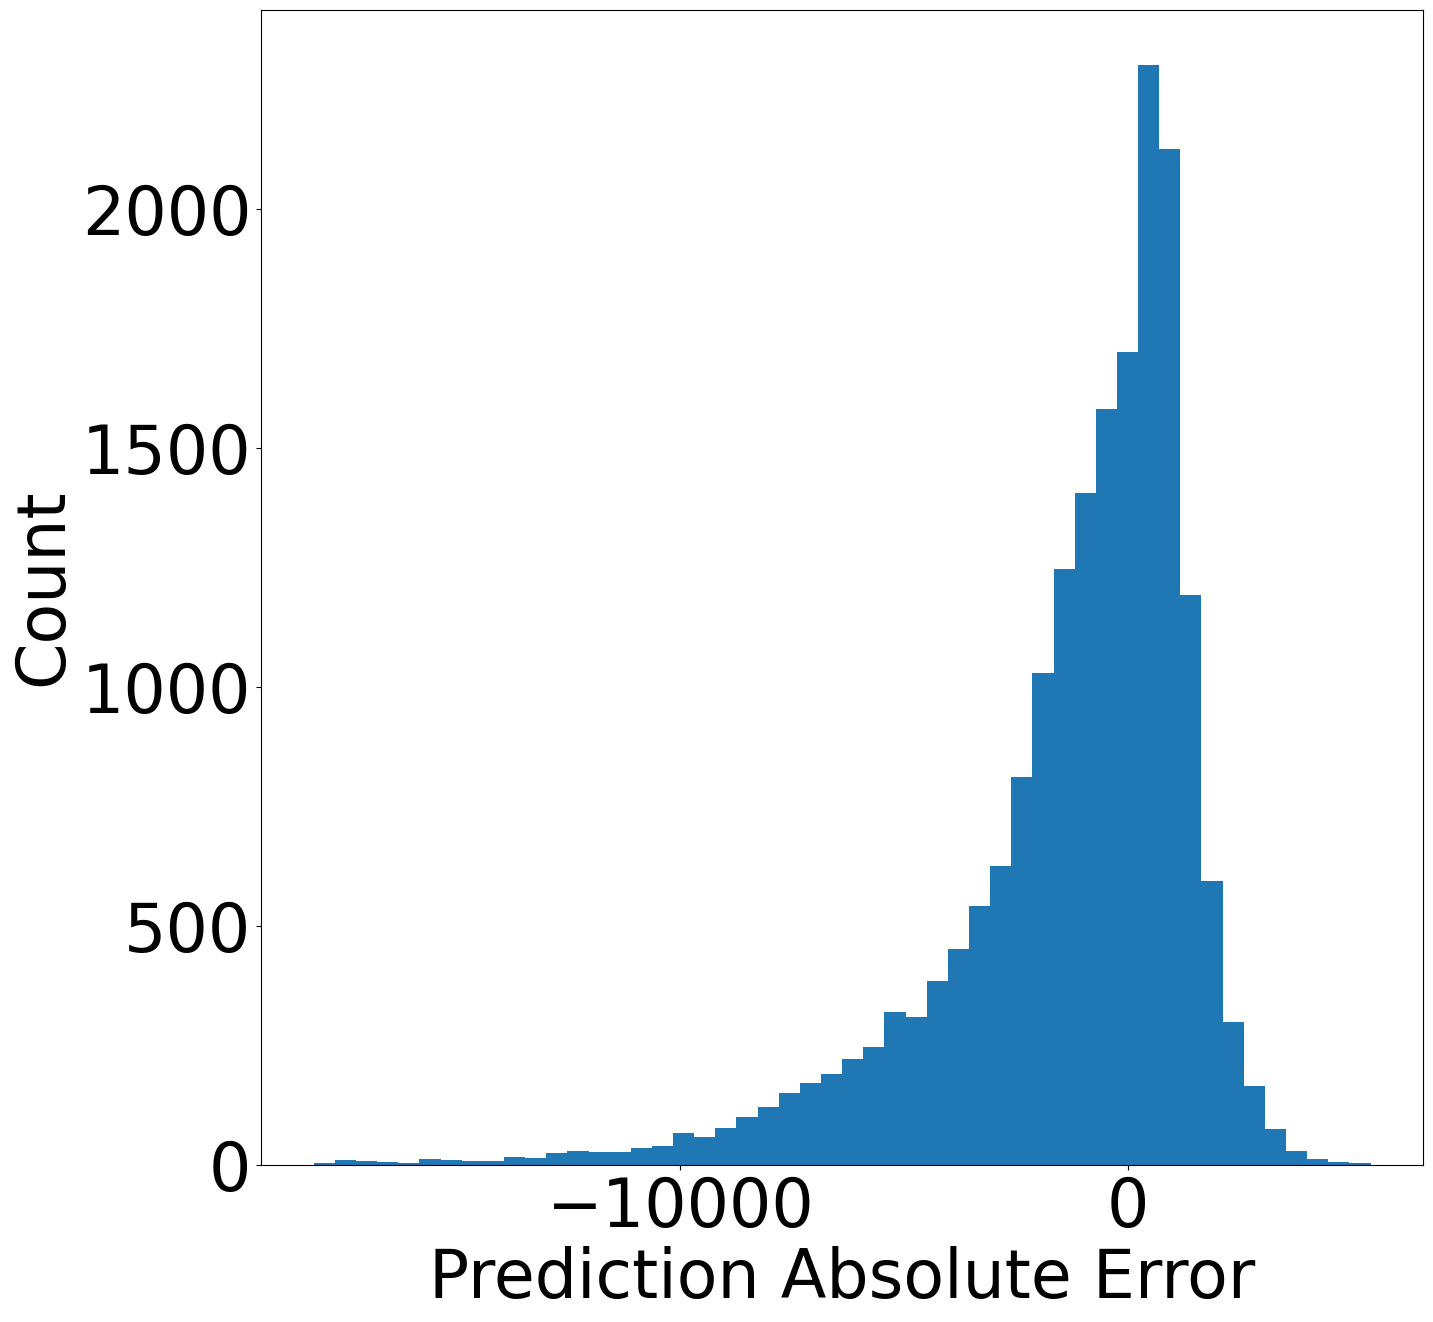

In [19]:
plt.figure(figsize=(15,15))
plt.hist(error, bins = 50)
plt.xlabel("Prediction Absolute Error")
_ = plt.ylabel("Count")

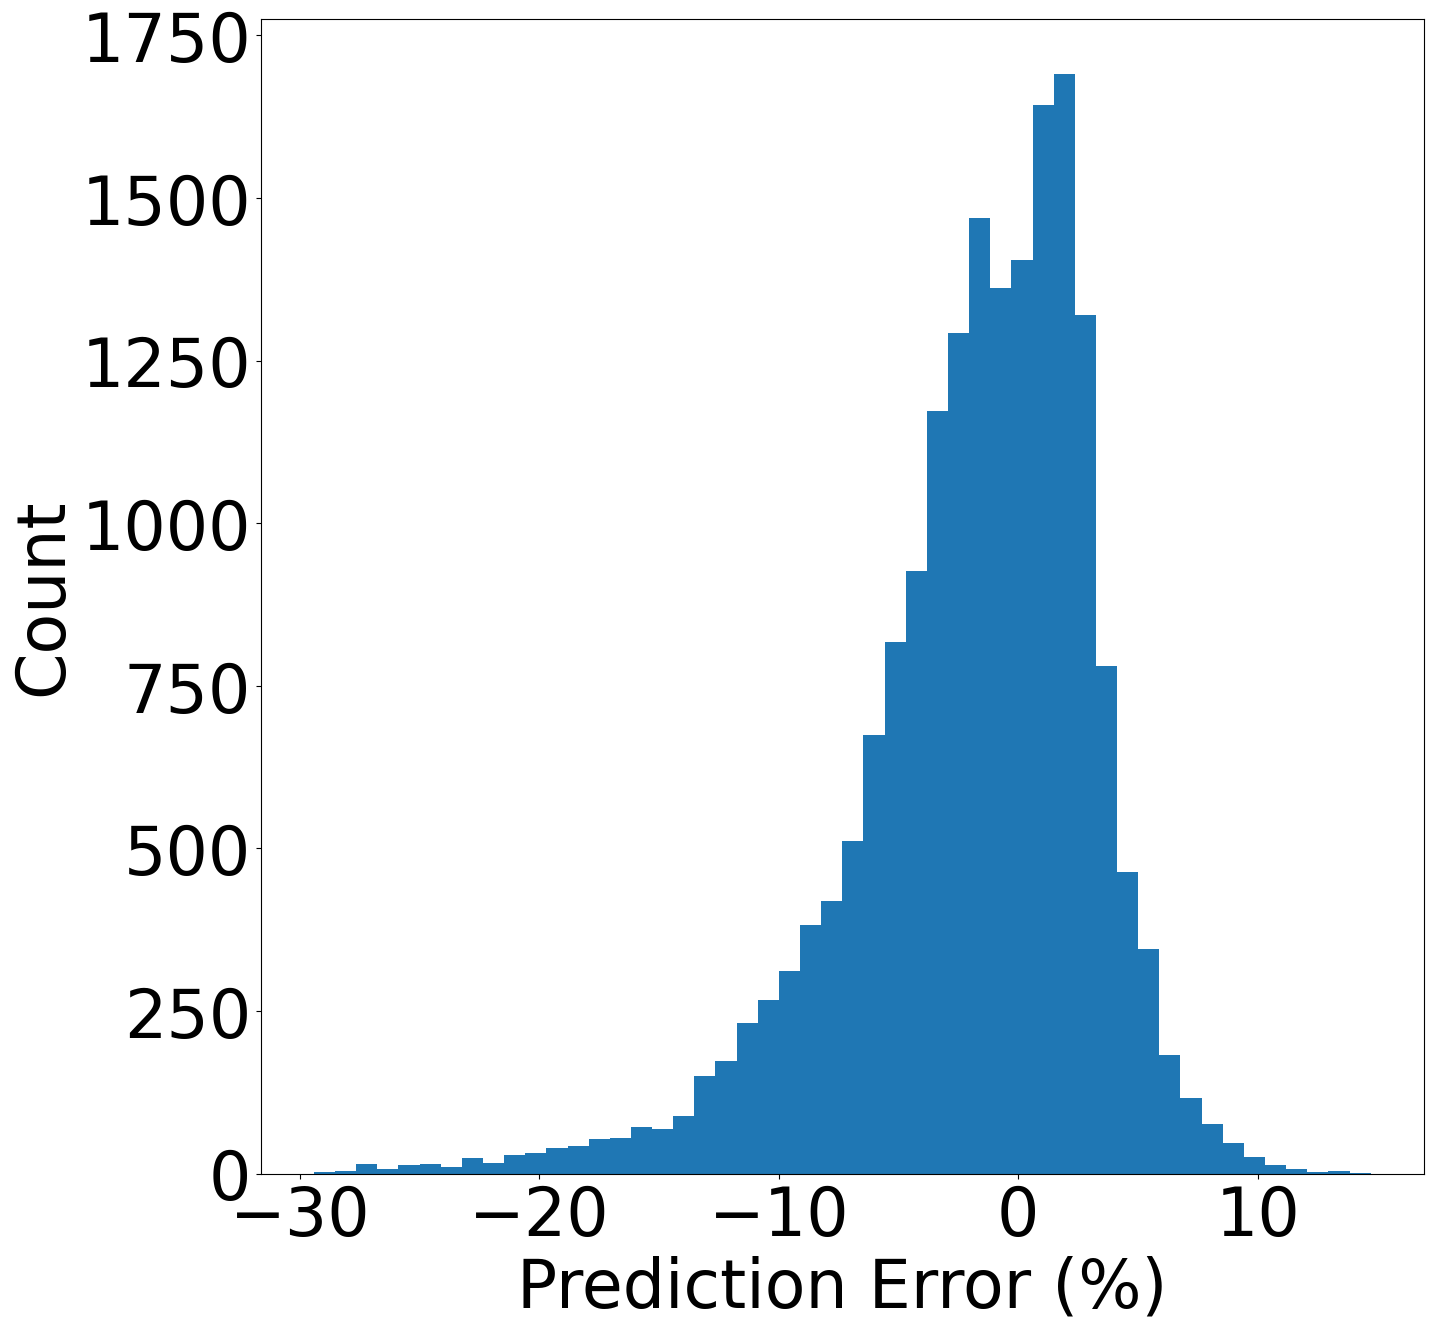

In [20]:
plt.figure(figsize=(15,15))
plt.hist(rerror, bins = 50)
plt.xlabel("Prediction Error (%)")
_ = plt.ylabel("Count")

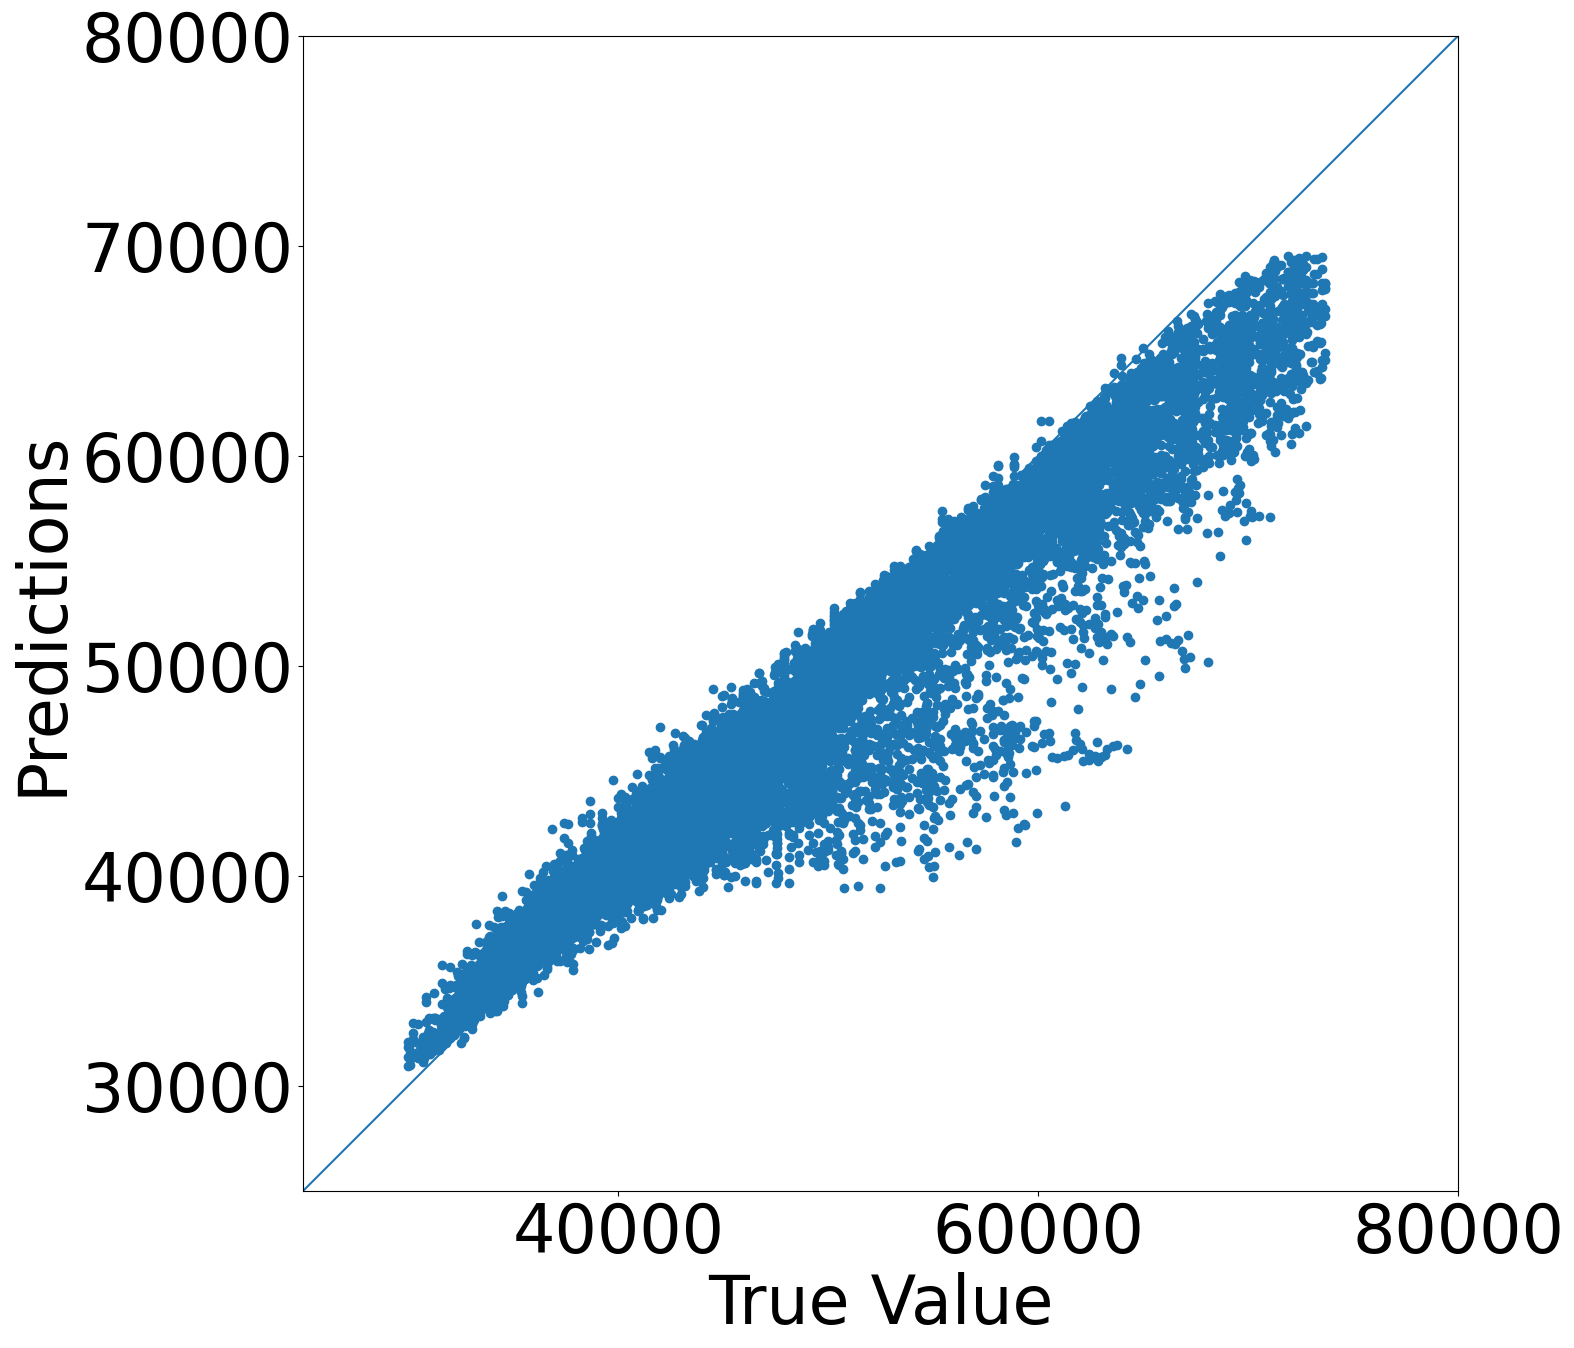

In [21]:
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels['actual'], predictions)
plt.xlabel('True Value')
plt.ylabel('Predictions')
lims = [25000, 80000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [22]:
end = datetime.datetime.now()
print('total time:', end-start)

total time: 0:07:30.554272


In [23]:
from keras.models import save_model
save_model(model,'Models/LSTM_model_1.0.1.h5',include_optimizer=True)
np.save('Models/LSTM_history_1.0.1.npy',history.history)

In [24]:
from keras.models import load_model
model = load_model('Models/LSTM_model_1.0.1.h5')

In [25]:
np.save('Models/predictions1.0.1', np.array(predictions['predict']))